## moving-average crossover 

<https://ntguardian.wordpress.com/2016/09/26/introduction-stock-market-data-python-2/>

1. Trade the asset when the fast moving average crosses over the slow moving average.
2. Exit the trade when the fast moving average crosses over the slow moving average again.

In [1]:
import pandas as pd
from pandas_datareader import data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

start = datetime.datetime(2010,1,1)
end = datetime.date.today()
apple = web.DataReader("AAPL", "yahoo", start, end)

Populating the interactive namespace from numpy and matplotlib


In [2]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)#ma20
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,20d-50d
Date,,,,,,,,,
2016-12-19,115.800003,117.379997,115.750000,116.639999,27675400,116.639999,112.39,112.88,-0.49
2016-12-20,116.739998,117.500000,116.680000,116.949997,20905800,116.949997,112.65,112.90,-0.25
2016-12-21,116.800003,117.400002,116.779999,117.059998,24216900,117.059998,112.91,112.92,-0.01
2016-12-22,116.349998,116.510002,115.639999,116.290001,25789800,116.290001,113.16,112.90,0.26
2016-12-23,115.589996,116.519997,115.589996,116.519997,14181200,116.519997,113.40,112.89,0.51


We will refer to the sign of this difference as the regime; that is, if the fast moving average is above the slow moving average, this is a bullish regime (the bulls rule), and a bearish regime (the bears rule) holds when the fast moving average is below the slow moving average. 

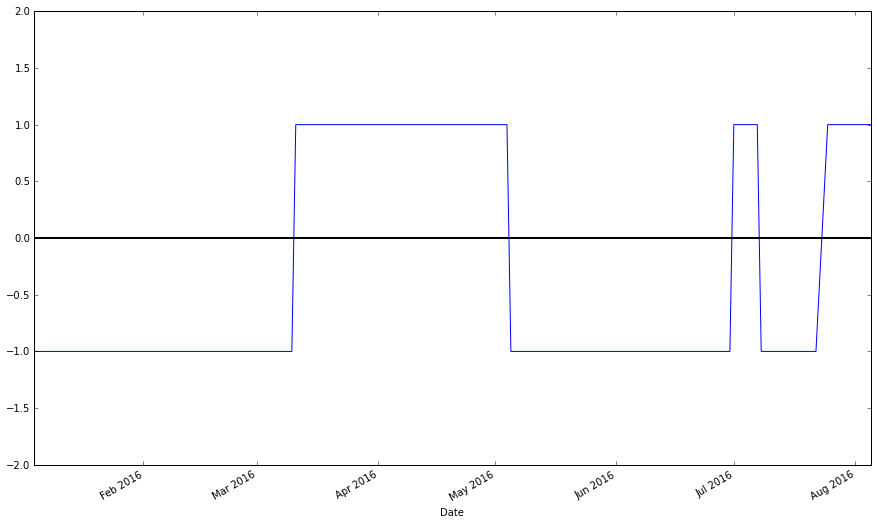

In [3]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector,
#and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)

# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, 
#and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])#refer to the sign of this difference as the regime

apple.loc['2016-01-01':'2016-08-07',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

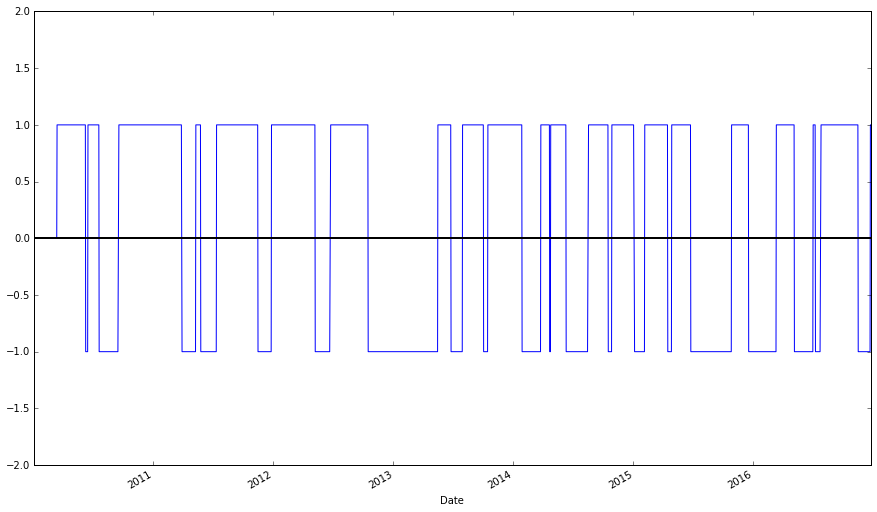

In [4]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [5]:
apple["Regime"].value_counts()

 1    1019
-1     689
 0      50
Name: Regime, dtype: int64

Trading signals appear at regime changes. -1 indicating “sell”, 1 indicating “buy”, and 0 no action.

In [6]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.ix[-1, "Regime"] = regime_orig
apple.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,20d-50d,Regime,Signal
Date,,,,,,,,,,,
2016-12-19,115.800003,117.379997,115.750000,116.639999,27675400,116.639999,112.39,112.88,-0.49,-1.0,0.0
2016-12-20,116.739998,117.500000,116.680000,116.949997,20905800,116.949997,112.65,112.90,-0.25,-1.0,0.0
2016-12-21,116.800003,117.400002,116.779999,117.059998,24216900,117.059998,112.91,112.92,-0.01,-1.0,0.0
2016-12-22,116.349998,116.510002,115.639999,116.290001,25789800,116.290001,113.16,112.90,0.26,1.0,1.0
2016-12-23,115.589996,116.519997,115.589996,116.519997,14181200,116.519997,113.40,112.89,0.51,1.0,-1.0


In [7]:
apple["Signal"].value_counts()

 0.0    1714
-1.0      22
 1.0      21
Name: Signal, dtype: int64

In [8]:
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2010-03-16,224.449997,1.0,Buy
2010-06-11,253.509995,-1.0,Sell
2010-06-18,274.070011,1.0,Buy
2010-07-22,259.020000,-1.0,Sell
2010-09-20,283.230007,1.0,Buy
2011-03-30,348.630009,0.0,Sell
2011-03-31,348.510006,-1.0,Sell
2011-05-12,346.569988,1.0,Buy
2011-05-27,337.409992,-1.0,Sell


In [9]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2010-03-16,2010-06-11,224.449997,29.059998
2010-06-18,2010-07-22,274.070011,-15.050011
2010-09-20,2011-03-30,283.230007,65.400002
2011-05-12,2011-05-27,346.569988,-9.159996
2011-07-14,2011-11-17,357.770004,19.639996
2011-12-28,2012-05-09,402.640003,166.540020
2012-06-25,2012-10-17,570.770020,73.839981
2013-05-17,2013-06-26,433.260010,-35.190018
2013-07-31,2013-10-03,452.529984,30.880012


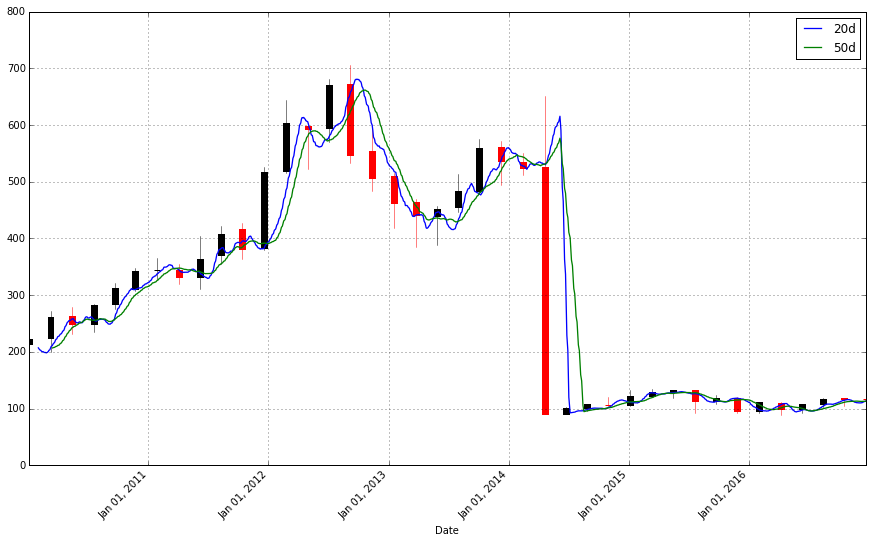

In [11]:
import pandaStock
pandaStock.pandas_candlestick_ohlc(apple, stick = 45, otherseries = ["20d", "50d"])

## adjusted data

In [12]:
import pandaStock

In [13]:
apple_adj = pandaStock.ohlc_adj(apple)

In [14]:
apple_adj["20d"] = np.round(apple_adj["Close"].rolling(window = 20, center = False).mean(), 2)
apple_adj["50d"] = np.round(apple_adj["Close"].rolling(window = 50, center = False).mean(), 2)
apple_adj["200d"] = np.round(apple_adj["Close"].rolling(window = 200, center = False).mean(), 2)
 
apple_adj['20d-50d'] = apple_adj['20d'] - apple_adj['50d']

In [15]:
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] > 0, 1, 0)
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] < 0, -1, apple_adj["Regime"])
regime_orig = apple_adj.ix[-1, "Regime"]
apple_adj.ix[-1, "Regime"] = 0
apple_adj["Signal"] = np.sign(apple_adj["Regime"] - apple_adj["Regime"].shift(1))
apple_adj.ix[-1, "Regime"] = regime_orig
apple_adj_signals = pd.concat([
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == 1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == -1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])

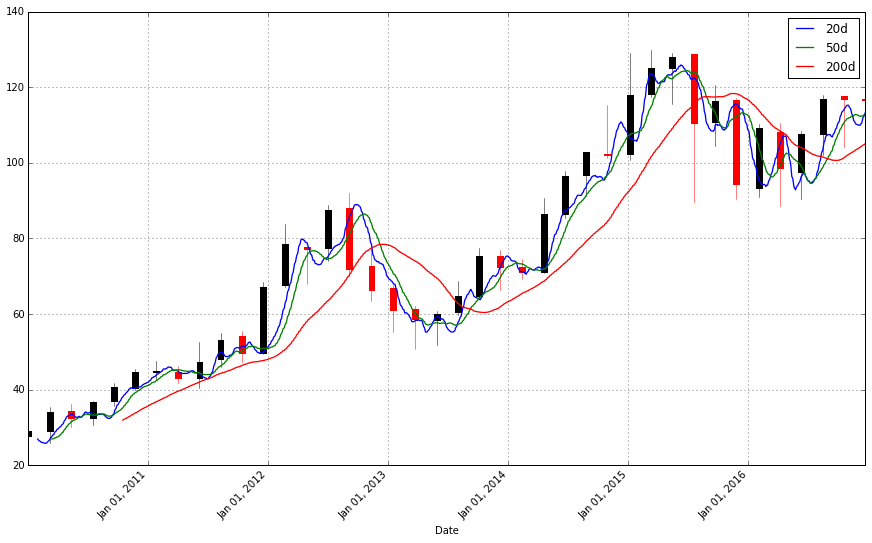

In [16]:
apple_adj_signals.sort_index(inplace = True)
apple_adj_long_profits = pd.DataFrame({
        "Price": apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
                                  apple_adj_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_adj_signals["Price"].loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].index
    })
 
pandaStock.pandas_candlestick_ohlc(apple_adj, stick = 45, otherseries = ["20d", "50d", "200d"])

## simulation

Let’s now create a simulated portfolio of $1,000,000, and see how it would behave, according to the rules we have established. 
This includes:

- Investing only 10% of the portfolio in any trade
- Exiting the position if losses exceed 20% of the value of the trade.

In [17]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_adj_long_profits.index,
                            "End": apple_adj_long_profits["End Date"]})
apple_adj_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple_adj.loc[x["Start"]:x["End"], "Low"]), axis = 1)
apple_adj_long_profits

,End Date,Price,Profit,Low
Date,,,,
2010-03-16,2010-06-10,29.205718,3.390961,25.926661
2010-06-18,2010-07-22,35.662337,-1.958327,31.177056
2010-09-20,2011-03-30,36.854247,8.509931,35.783347
2011-05-12,2011-05-27,45.096125,-1.191910,42.864549
2011-07-14,2011-11-17,46.553486,2.555581,45.935408
2011-12-28,2012-05-09,52.392027,21.670398,52.114867
2012-06-25,2012-10-17,74.269317,9.968284,73.597889
2013-05-17,2013-06-26,57.587132,-4.677312,52.589494
2013-07-31,2013-10-04,60.148417,4.477846,59.736379


In [18]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_adj_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,End Date,End Port. Value,Profit per Share,Share Price,Shares,Start Port. Value,Stop-Loss Triggered,Total Profit,Trade Value
2010-03-16,2010-06-10,1.011529e+06,3.390961,29.205718,3400.0,1.000000e+06,0.0,11529.2674,99299.4412
2010-06-18,2010-07-22,1.006046e+06,-1.958327,35.662337,2800.0,1.011529e+06,0.0,-5483.3156,99854.5436
2010-09-20,2011-03-30,1.029023e+06,8.509931,36.854247,2700.0,1.006046e+06,0.0,22976.8137,99506.4669
2011-05-12,2011-05-27,1.026401e+06,-1.191910,45.096125,2200.0,1.029023e+06,0.0,-2622.2020,99211.4750
2011-07-14,2011-11-17,1.032023e+06,2.555581,46.553486,2200.0,1.026401e+06,0.0,5622.2782,102417.6692
2011-12-28,2012-05-09,1.073197e+06,21.670398,52.392027,1900.0,1.032023e+06,0.0,41173.7562,99544.8513
2012-06-25,2012-10-17,1.087152e+06,9.968284,74.269317,1400.0,1.073197e+06,0.0,13955.5976,103977.0438
2013-05-17,2013-06-26,1.078733e+06,-4.677312,57.587132,1800.0,1.087152e+06,0.0,-8419.1616,103656.8376
2013-07-31,2013-10-04,1.086345e+06,4.477846,60.148417,1700.0,1.078733e+06,0.0,7612.3382,102252.3089
2013-10-16,2014-01-28,1.088132e+06,1.116789,67.045247,1600.0,1.086345e+06,0.0,1786.8624,107272.3952


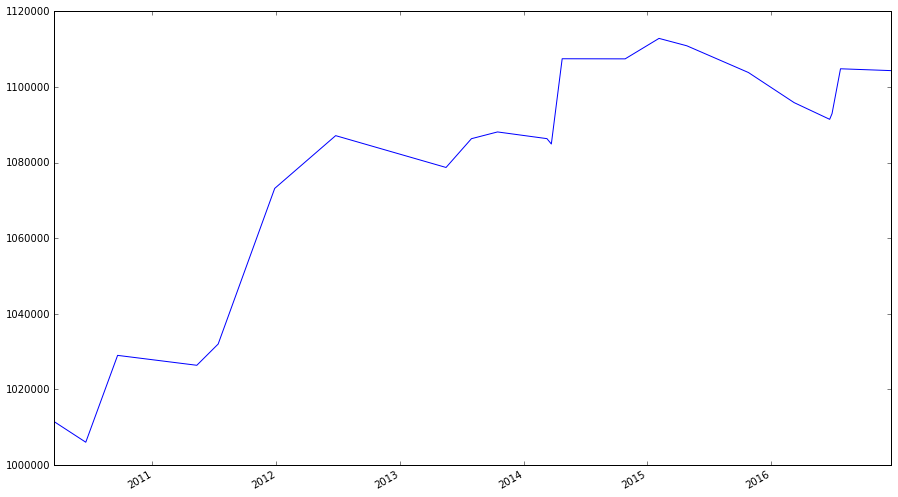

In [19]:
apple_backtest["End Port. Value"].plot()

>Notice that this strategy never lead to our stop-loss order being triggered

## more than one stock Portforlio

In [20]:
# Get more stocks
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
facebook = web.DataReader("FB", "yahoo", start, end)
twitter = web.DataReader("TWTR", "yahoo", start, end)
netflix = web.DataReader("NFLX", "yahoo", start, end)
amazon = web.DataReader("AMZN", "yahoo", start, end)
yahoo = web.DataReader("YHOO", "yahoo", start, end)
sony = web.DataReader("SNY", "yahoo", start, end)
nintendo = web.DataReader("NTDOY", "yahoo", start, end)
ibm = web.DataReader("IBM", "yahoo", start, end)
hp = web.DataReader("HPQ", "yahoo", start, end)

In [21]:
reload(pandaStock)

<module 'pandaStock' from 'pandaStock.py'>

In [23]:
signals = pandaStock.ma_crossover_orders([("AAPL", pandaStock.ohlc_adj(apple)),
                              ("MSFT",  pandaStock.ohlc_adj(microsoft)),
                              ("GOOG",  pandaStock.ohlc_adj(google)),
                              ("FB",    pandaStock.ohlc_adj(facebook)),
                              ("TWTR",  pandaStock.ohlc_adj(twitter)),
                              ("NFLX",  pandaStock.ohlc_adj(netflix)),
                              ("AMZN",  pandaStock.ohlc_adj(amazon)),
                              ("YHOO",  pandaStock.ohlc_adj(yahoo)),
                              ("SNY",   pandaStock.ohlc_adj(yahoo)),
                              ("NTDOY", pandaStock.ohlc_adj(nintendo)),
                              ("IBM",   pandaStock.ohlc_adj(ibm)),
                              ("HPQ",   pandaStock.ohlc_adj(hp))],
                            fast = 20, slow = 50)
signals

Price  Regime Signal
Date       Symbol                           
2010-03-16 AAPL     29.205718     1.0    Buy
           AMZN    131.789993     1.0    Buy
           GOOG    282.318173    -1.0   Sell
           HPQ      20.366572     1.0    Buy
           IBM     109.569219     1.0    Buy
           MSFT     24.511988    -1.0   Sell
           NFLX     10.090000     1.0    Buy
           NTDOY    37.099998     1.0    Buy
           SNY      16.360001    -1.0   Sell
           YHOO     16.360001    -1.0   Sell
2010-03-17 SNY      16.500000     1.0    Buy
           YHOO     16.500000     1.0    Buy
2010-03-22 GOOG    278.472004     1.0    Buy
2010-03-23 MSFT     24.937629     1.0    Buy
2010-05-03 GOOG    265.035411    -1.0   Sell
2010-05-10 HPQ      19.102171    -1.0   Sell
2010-05-14 NTDOY    35.799999    -1.0   Sell
2010-05-17 SNY      16.270000    -1.0   Sell
           YHOO     16.270000    -1.0   Sell
2010-05-19 AMZN    124.589996    -1.0   Sell
           MSFT     23.675248    -1.0   Sell
2010-05-21 IBM     107.349121    -1.0   Sell
2010-06-10 AAPL     32.596679     0.0   Sell
2010-06-11 AAPL     32.987041    -1.0   Sell
2010-06-18 AAPL     35.662337     1.0    Buy
2010-06-28 IBM     110.396183     1.0    Buy
2010-07-01 IBM     104.909758    -1.0   Sell
2010-07-06 IBM     105.671524     1.0    Buy
2010-07-09 NTDOY    36.950001     1.0    Buy
2010-07-20 IBM     108.316311    -1.0   Sell
...                       ...     ...    ...
2016-10-19 SNY      42.730000    -1.0   Sell
           YHOO     42.730000    -1.0   Sell
2016-10-20 MSFT     56.865839     0.0   Sell
2016-10-21 MSFT     59.259667     1.0    Buy
2016-10-26 TWTR     17.290001    -1.0   Sell
2016-10-31 HPQ      14.367872     0.0   Sell
           NTDOY    30.090000    -1.0   Sell
2016-11-01 HPQ      14.229053    -1.0   Sell
2016-11-08 FB      124.220001    -1.0   Sell
2016-11-10 AMZN    742.380005    -1.0   Sell
2016-11-15 AAPL    107.110001    -1.0   Sell
2016-11-18 GOOG    760.539978    -1.0   Sell
           HPQ      15.736241     1.0    Buy
           IBM     160.389999     1.0    Buy
2016-12-12 NTDOY    32.090000     1.0    Buy
           TWTR     18.930000     1.0    Buy
2016-12-21 AAPL    117.059998     1.0    Buy
           NTDOY    25.730000    -1.0   Sell
2016-12-23 AAPL    116.519997     1.0   Sell
           AMZN    760.590027    -1.0    Buy
           FB      117.269997    -1.0    Buy
           GOOG    789.909973     1.0    Buy
           HPQ      15.100000     1.0   Sell
           IBM     166.710007     1.0   Sell
           MSFT     63.240002     1.0   Sell
           NFLX    125.589996     1.0   Sell
           NTDOY    25.040001    -1.0    Buy
           SNY      38.660000    -1.0    Buy
           TWTR     16.500000     1.0   Sell
           YHOO     38.660000    -1.0    Buy

[498 rows x 3 columns]

In [24]:
bk = pandaStock.backtest(signals, 1000000)
bk


End Cash  Portfolio Value  Profit per Share  \
Date       Symbol                                                    
2010-03-16 AAPL    9.007006e+05     1.000000e+06          0.000000   
           AMZN    8.084476e+05     1.000000e+06          0.000000   
           GOOG    8.084476e+05     1.000000e+06          0.000000   
           HPQ     7.086514e+05     1.000000e+06          0.000000   
           IBM     6.100391e+05     1.000000e+06          0.000000   
           MSFT    6.100391e+05     1.000000e+06          0.000000   
           NFLX    5.101481e+05     1.000000e+06          0.000000   
           NTDOY   4.136881e+05     1.000000e+06          0.000000   
           SNY     4.136881e+05     1.000000e+06          0.000000   
           YHOO    4.136881e+05     1.000000e+06          0.000000   
2010-03-17 SNY     3.146881e+05     1.000000e+06          0.000000   
           YHOO    2.156881e+05     1.000000e+06          0.000000   
2010-03-22 GOOG    1.321465e+05     1.000000e+06          0.000000   
2010-03-23 MSFT    3.239595e+04     1.000000e+06          0.000000   
2010-05-03 GOOG    1.119066e+05     9.959690e+05        -13.436593   
2010-05-10 HPQ     2.055072e+05     9.897735e+05         -1.264401   
2010-05-14 NTDOY   2.985872e+05     9.863935e+05         -1.299999   
2010-05-17 SNY     3.962072e+05     9.850135e+05         -0.230000   
           YHOO    4.938272e+05     9.836335e+05         -0.230000   
2010-05-19 AMZN    5.810402e+05     9.785935e+05         -7.199997   
           MSFT    6.757412e+05     9.735439e+05         -1.262381   
2010-05-21 IBM     7.723554e+05     9.715458e+05         -2.220098   
2010-06-10 AAPL    8.831841e+05     9.830751e+05          3.390961   
2010-06-11 AAPL    8.831841e+05     9.830751e+05          3.781323   
2010-06-18 AAPL    7.868958e+05     9.830751e+05          0.000000   
2010-06-28 IBM     6.985789e+05     9.830751e+05          0.000000   
2010-07-01 IBM     7.825067e+05     9.786860e+05         -5.486425   
2010-07-06 IBM     6.874023e+05     9.786860e+05          0.000000   
2010-07-09 NTDOY   5.913323e+05     9.786860e+05          0.000000   
2010-07-20 IBM     6.888170e+05     9.810663e+05          2.644787   
...                         ...              ...               ...   
2016-10-19 SNY     1.317123e+05     1.940779e+06          4.739998   
           YHOO    3.410893e+05     1.964005e+06          4.739998   
2016-10-20 MSFT    5.287466e+05     1.962661e+06         -0.407249   
2016-10-21 MSFT    3.331897e+05     1.962661e+06          0.000000   
2016-10-26 TWTR    5.216507e+05     1.965386e+06          0.250000   
2016-10-31 HPQ     7.228009e+05     1.979897e+06          1.036478   
           NTDOY   9.274129e+05     1.996149e+06          2.389999   
2016-11-01 HPQ     9.274129e+05     1.996149e+06          0.897659   
2016-11-08 FB      1.113743e+06     2.000034e+06          2.590004   
2016-11-10 AMZN    1.336457e+06     2.054916e+06        182.940003   
2016-11-15 AAPL    1.539966e+06     2.075415e+06         10.789007   
2016-11-18 GOOG    1.692074e+06     2.070335e+06        -25.400024   
           HPQ     1.485929e+06     2.070335e+06          0.000000   
           IBM     1.293461e+06     2.070335e+06          0.000000   
2016-12-12 NTDOY   1.088085e+06     2.070335e+06          0.000000   
           TWTR    8.817481e+05     2.070335e+06          0.000000   
2016-12-21 AAPL    6.827461e+05     2.070335e+06          0.000000   
           NTDOY   8.474181e+05     2.029631e+06         -6.360000   
2016-12-23 AAPL    1.045502e+06     2.028713e+06         -0.540001   
           AMZN    1.045502e+06     2.028713e+06        201.150025   
           FB      1.045502e+06     2.028713e+06         -4.360000   
           GOOG    8.875201e+05     2.028713e+06          0.000000   
           HPQ     1.085330e+06     2.020378e+06         -0.636241   
           IBM     1.285382e+06     2.027962e+06          6.320008   
           MSFT    1.494074e+06  

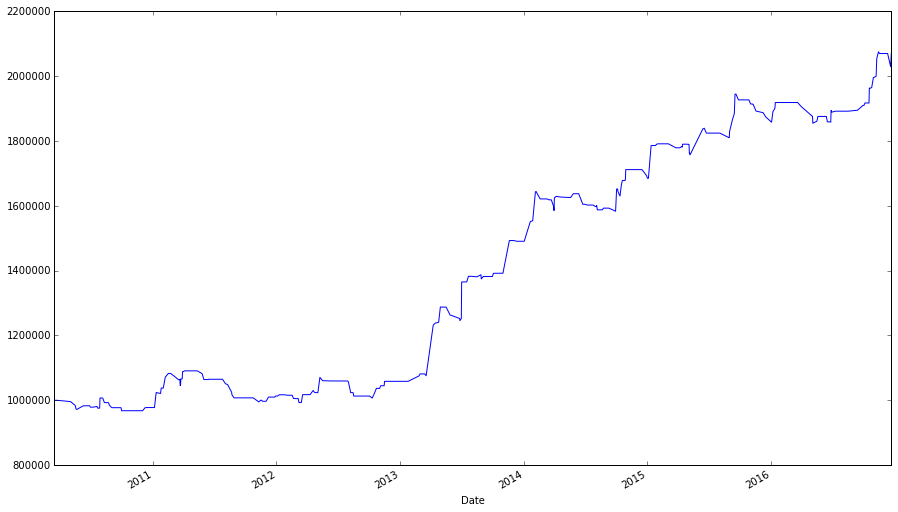

In [25]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()

## benchmarking: SPY

Whenever you evaluate a trading system, there is one strategy that you should always check, one that beats all but a handful of managed mutual funds and investment managers: buy and hold SPY.SPY is an exchange-traded fund (a mutual fund that is traded on the market like a stock) whose value effectively represents the value of the stocks in the S&P 500 stock index.

In [26]:
spyder = web.DataReader("SPY", "yahoo", start, end)
spyder.iloc[[0,-1],:]

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,118944600,98.214371
2016-12-23,225.429993,225.720001,225.210007,225.710007,36251400,225.710007


In [27]:
batches = 1000000 // np.ceil(100 * spyder.ix[0,"Adj Close"]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * spyder.ix[0,"Adj Close"] # How much money is used to buy SPY
final_val = batches * batch * spyder.ix[-1,"Adj Close"] + (1000000 - trade_val) # Final value of the portfolio
final_val

2287705.9236000003